# Imports




In [12]:
import pandas as pd
import seaborn as sns
from nltk import download
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from wordcloud import WordCloud as wordBlob
from string import punctuation as punctuations
from nltk.stem import PorterStemmer as Stemmer

# Loading SMS Data

In [4]:
df = pd.read_csv("data.csv", encoding="latin")
df = df.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"])
df.rename({"v1": "type", "v2": "text"}, axis=1, inplace=True)
df = df[["text", "type"]]
df.sample(5)

,text,type
4201,Are you happy baby ? Are you alright ? Did you...,ham
4695,A guy who gets used but is too dumb to realize...,ham
605,TaKe CaRE n gET WeLL sOOn,ham
2246,Hi ya babe x u 4goten bout me?' scammers getti...,spam
1741,I can do that! I want to please you both insid...,ham


# SMS Data Imbalance

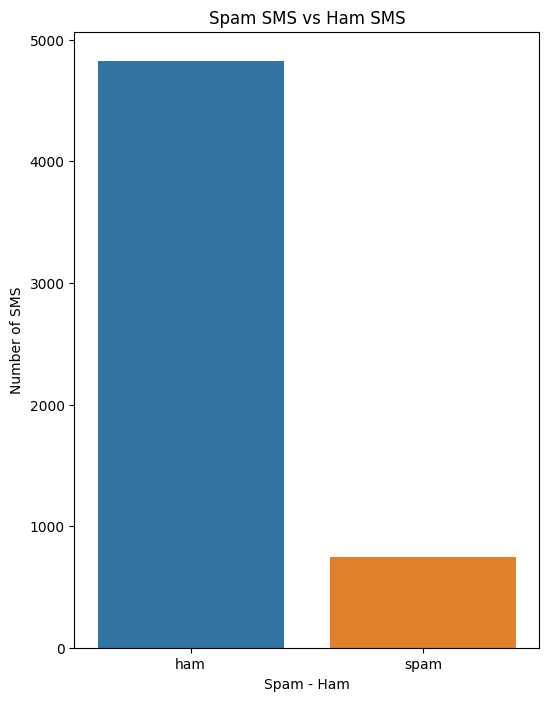

In [5]:
plt.figure(figsize=(6, 8))
sns.countplot(x="type", data=df)
plt.title("Spam SMS vs Ham SMS")
plt.xlabel("Spam - Ham")
plt.ylabel("Number of SMS")
plt.show()

# SMS Data Distribution

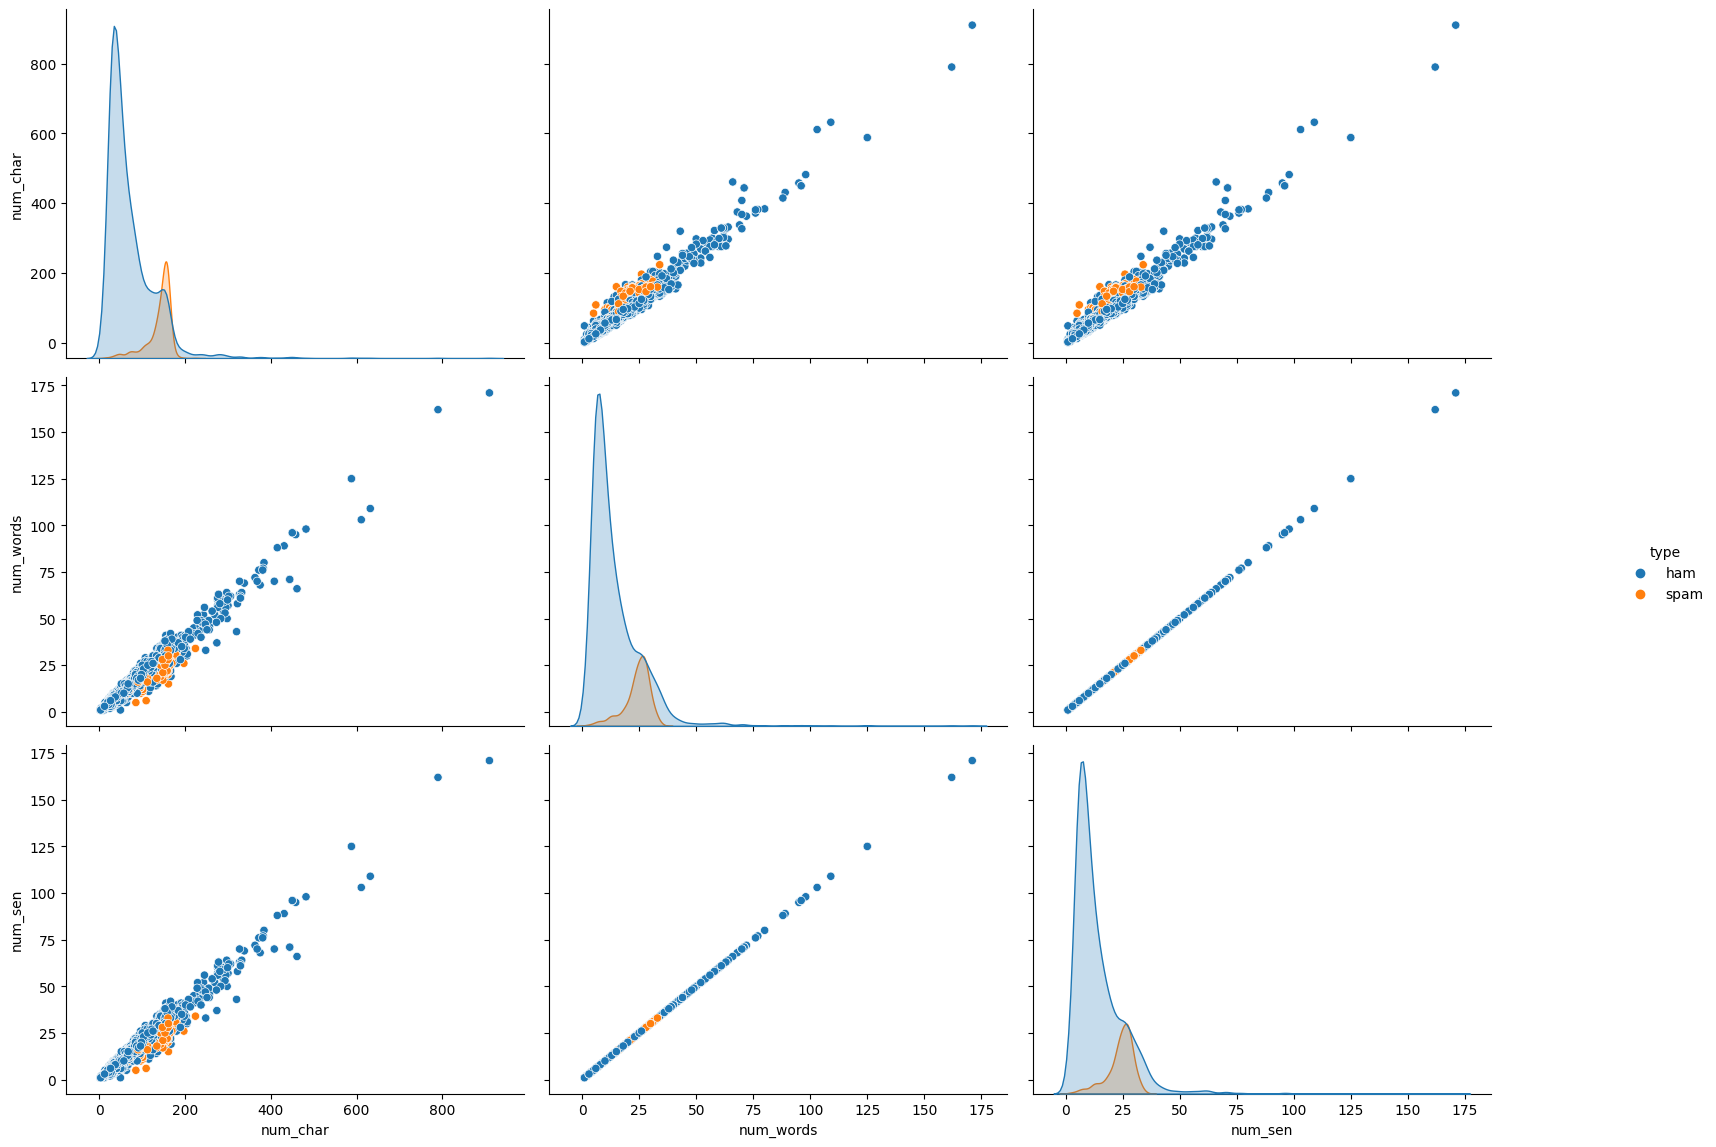

In [6]:
df["num_char"]= df["text"].apply(len)
df["num_words"]= df["text"].apply(lambda text: len(text.split()))
df["num_sen"]= df["text"].apply(lambda text: len(text.split()))
graphs = sns.pairplot(df, hue="type")
graphs.fig.set_figheight(12)
graphs.fig.set_figwidth(18)

# SMS Word Frequency

In [7]:
def words(category):
    word_bank = ""
    for sms, label in zip(df["text"], df["type"]):
        if label == category:
            word_bank += " ".join([word for word in sms.lower().split()])
    return word_bank

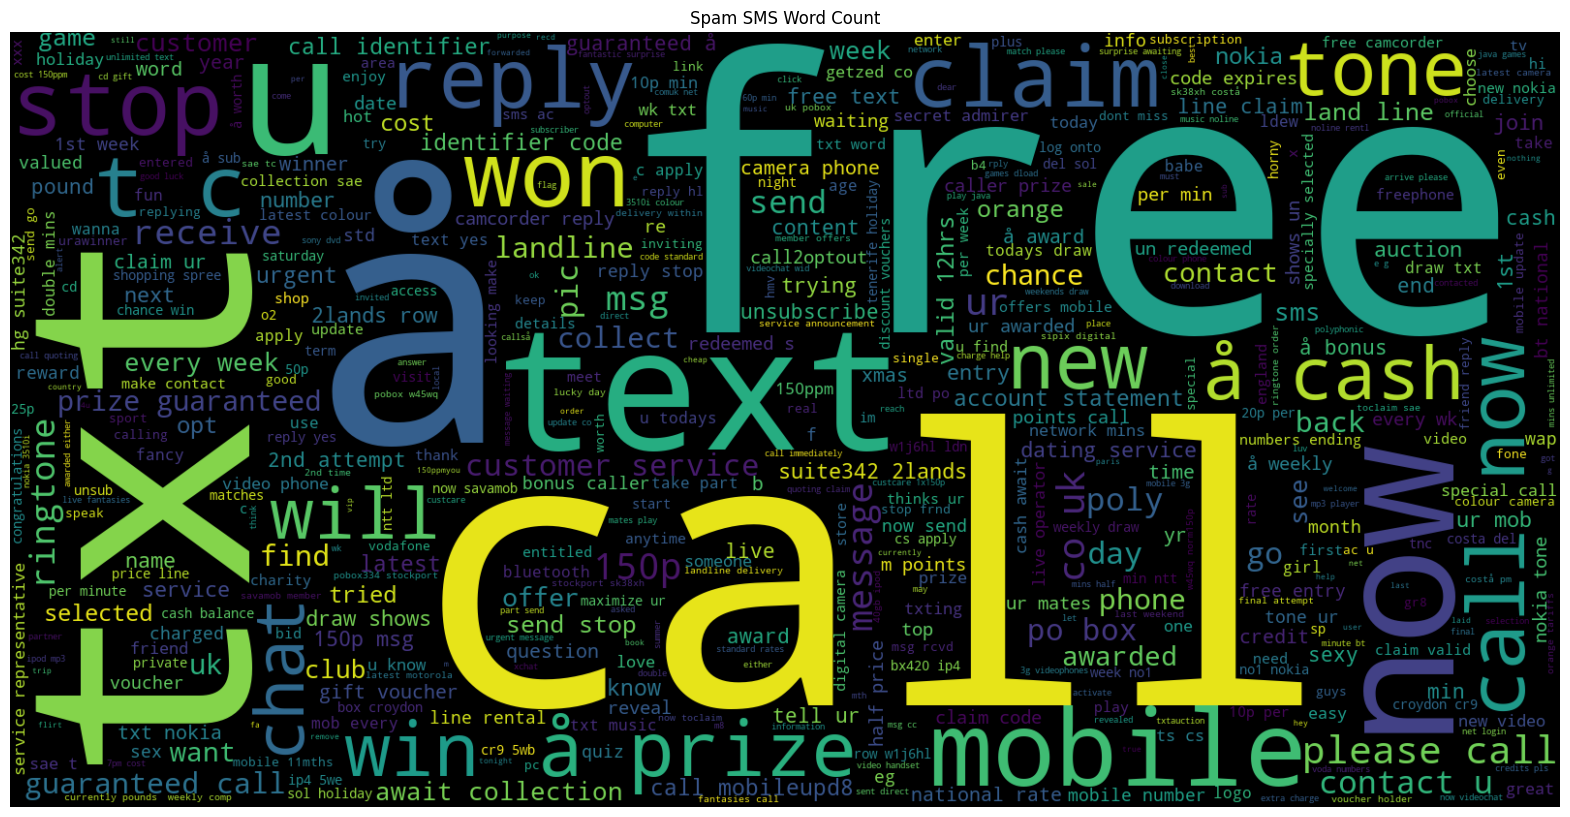

In [8]:
plt.figure(figsize = (20, 20))
plt.imshow(wordBlob(width=1600, height=800, max_words=500, background_color="black").generate(words("spam")), interpolation="bilinear")
plt.title("Spam SMS Word Count")
plt.axis("off")
plt.show()

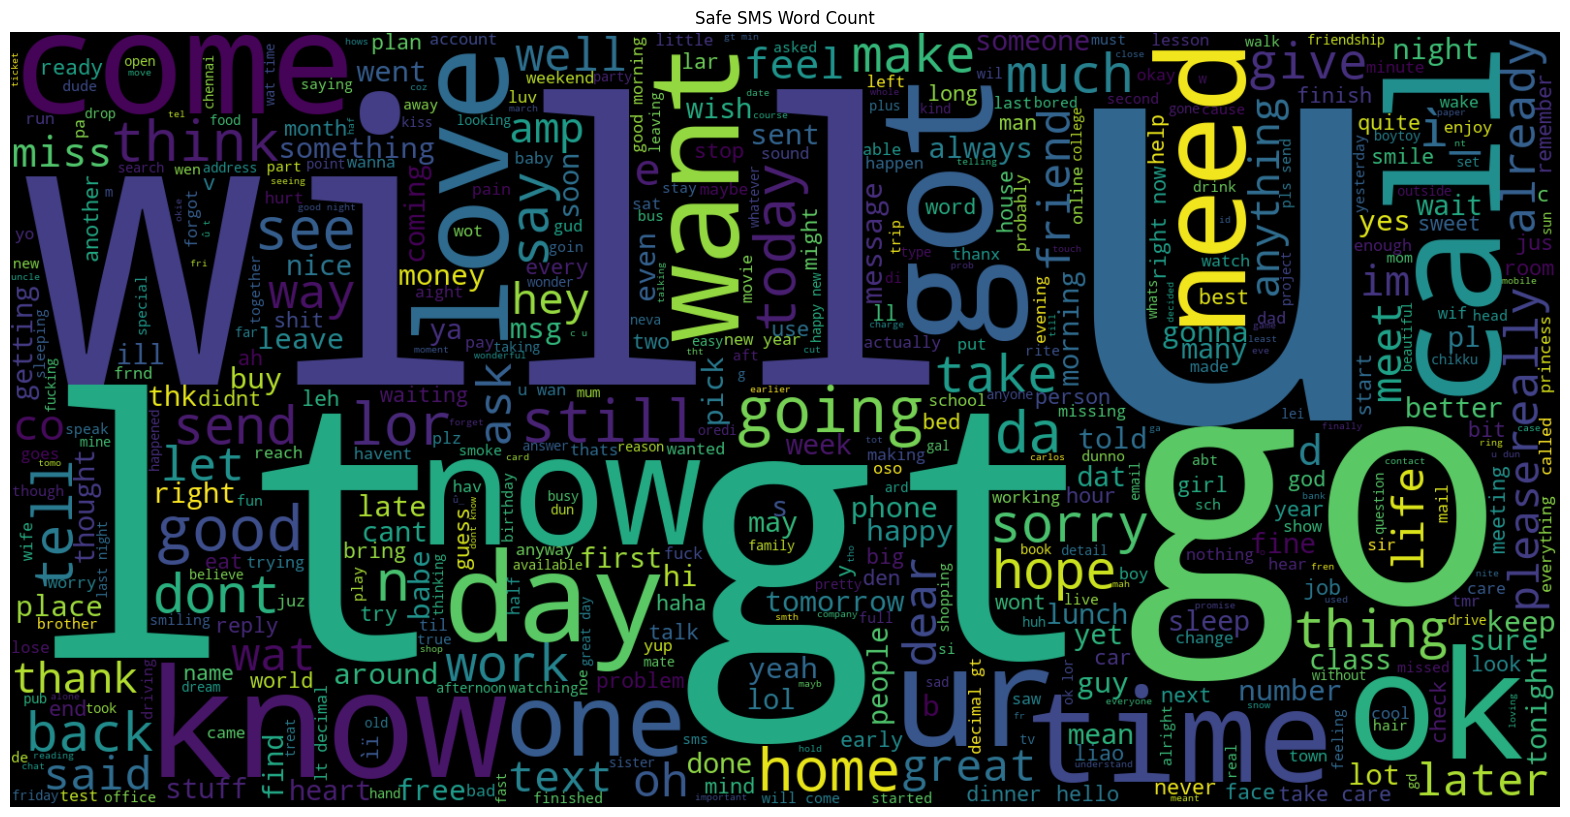

In [9]:
plt.figure(figsize = (20, 20))
plt.imshow(wordBlob(width=1600, height=800, max_words=500, background_color="black").generate(words("ham")), interpolation="bilinear")
plt.title("Safe SMS Word Count")
plt.axis("off")
plt.show()

# Custom Dictionary

In [13]:
# Dictionary Prerequisites
download("words")
download("stopwords")

[nltk_data] Downloading package words to /home/ubuntu/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
# Custom Dictionary - Initalize Base case
custom_dictionary = {"[pad]": 0, "[unknown]": 1, "[website]": 2, "[number]": 3}

# Adding punctuations into Custom Dictionary
for character in punctuations:
    if character not in custom_dictionary:
        custom_dictionary[character] = len(custom_dictionary)

# Loop through sms and save words into dictionary
for sentence in df["text"]:
    for word in sentence.lower().split():
        i = 0
        while i < len(word):
            # Word Case - Continously read letters to find the whole word
            if "a" <= word[i] <= "z":
                curr_word = ""
                while i < len(word) and "a" <= word[i] <= "z":
                    curr_word += word[i]
                    i += 1
                # Add stemmed word to dictionary if not stopword
                curr_word = Stemmer().stem(curr_word)
                if curr_word not in stopwords.words("english"):
                    if curr_word not in custom_dictionary:
                        custom_dictionary[curr_word] = len(custom_dictionary)
            elif "0" <= word[i] <= "9":
                # Number Case - Initalized Already
                i += 1
            elif word[i] in punctuations:
                # Special Characters Case - Initalized Already
                i += 1
            else:
                # Unknown Case - English characters supported only
                i += 1

# Length of Dictionary
print(f"\nThere are {len(custom_dictionary)} words in the dictionary")


There are 6260 words in the dictionary


In [ ]:
print(custom_dictionary)

# Processing SMS Data

In [15]:
def preprocess(sentences, dictionary):
    sentence = []
    for word in sentences.lower().split():
        # Website Case
        if "www." in word or "http:" in word or ".com" in word or "bit." in word or ".ly" in word or ".info" in word:
            sentence.append(dictionary["[website]"])
        else:
            i = 0
            while i < len(word):
                # Word Case
                if "a" <= word[i] <= "z":
                    # Get the whole word
                    curr_word = ''
                    while i < len(word) and "a" <= word[i] <= "z":
                        curr_word += word[i]
                        i += 1
                    # Stem the whole word
                    curr_word = Stemmer().stem(curr_word)
                    # Disregard if stopword
                    if curr_word not in stopwords.words("english"):
                        if curr_word in dictionary:
                            sentence.append(dictionary[curr_word])
                        else:
                            sentence.append(dictionary["[unknown]"])
                elif "0" <= word[i] <= "9":
                    # Number case --> Attempt to append whole number including decimals
                    while i < len(word) and "0" <= word[i] <= "9":
                        sentence.append(dictionary["[number]"])
                        i += 1
                elif word[i] in punctuations:
                    # Special Characters Case
                    sentence.append(dictionary[word[i]])
                    i += 1
                else:
                    # Unknown Case
                    sentence.append(dictionary["[unknown]"])
                    i += 1
    for i in range(300 - len(sentence)):
      sentence.append(0)
    return sentence

In [16]:
df["text"] = df["text"].apply(lambda text: preprocess(text, custom_dictionary))
df["type"] = df["type"].apply(lambda type: 1 if type == "spam" else 0)

# Saving Processed SMS

In [11]:
df[["text", "type"]].to_csv("sms.csv")